In [11]:
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as T
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import f1_score

In [1]:
img_path="./Dataset/InfraredSolarModules/"
meta_data_path="./Dataset/InfraredSolarModules/module_metadata.json"
class_mappings={"No-Anomaly":0,"Cell":1,
                "Cell-Multi":2,"Cracking":3,"Hot-Spot":4,
                "Hot-Spot-Multi":5,"Shadowing":6,"Diode":7,
                "Diode-Multi":8,"Vegetation":9,"Soiling":10,
                "Offline-Module":11
               }
class_keys=["No-Anomaly","Cell","Cell-Multi","Cracking","Hot-Spot","Hot-Spot-Multi","Shadowing","Diode",
                "Diode-Multi","Vegetation","Soiling","Offline-Module"]

In [13]:
with open(meta_data_path, 'r') as f:
    metadata = json.load(f)

In [14]:
dic={"image_path":[],"class":[]}
for key in metadata:
    dic["image_path"]+=[os.path.join(img_path,metadata[key]["image_filepath"])]
    num_class=class_mappings[metadata[key]["anomaly_class"]]
    dic["class"]+=[num_class]
df=pd.DataFrame(dic)
df["is_anomaly"]=df["class"]!=0
df["is_anomaly"]=df["is_anomaly"].astype(int)

![title]("")

In [15]:
df

,image_path,class,is_anomaly
0,/kaggle/input/infrared-solar-modules/InfraredS...,0,0
1,/kaggle/input/infrared-solar-modules/InfraredS...,0,0
2,/kaggle/input/infrared-solar-modules/InfraredS...,0,0
3,/kaggle/input/infrared-solar-modules/InfraredS...,0,0
4,/kaggle/input/infrared-solar-modules/InfraredS...,0,0
...,...,...,...
19995,/kaggle/input/infrared-solar-modules/InfraredS...,9,1
19996,/kaggle/input/infrared-solar-modules/InfraredS...,9,1
19997,/kaggle/input/infrared-solar-modules/InfraredS...,3,1
19998,/kaggle/input/infrared-solar-modules/InfraredS...,0,0


In [16]:
df.is_anomaly.value_counts()

is_anomaly
0    10000
1    10000
Name: count, dtype: int64

In [17]:
df["class"].value_counts()

class
0     10000
1      1877
9      1639
7      1499
2      1288
6      1056
3       940
11      827
4       249
5       246
10      204
8       175
Name: count, dtype: int64

In [18]:
sampled =(
    df
    .groupby('class', group_keys=False)
    .apply(lambda grp: grp.sample(n=5)) 
)

/tmp/ipykernel_36/1367527436.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(n=5))


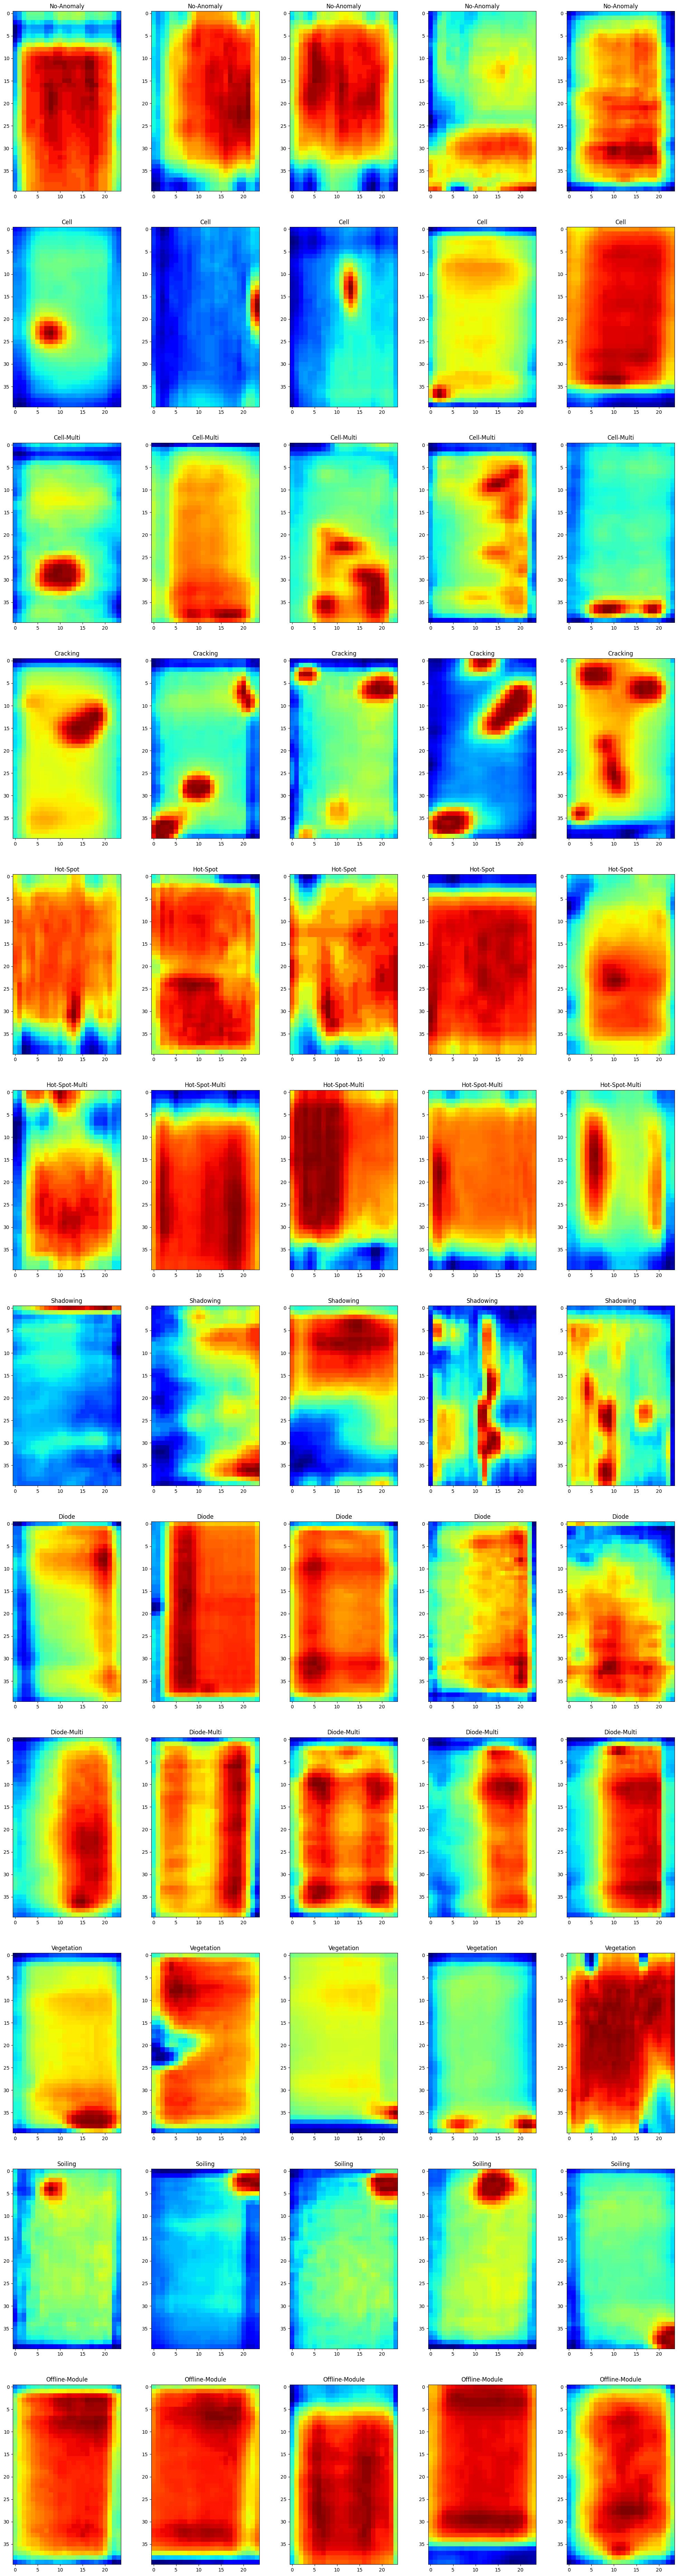

In [19]:
def show_samples(sampled):
    classes=sampled["class"].unique()
    fig,axes=plt.subplots(12,5,figsize=(25,96))
    axes=axes.reshape(-1)
    i=0
    for c in classes:
        paths=sampled[sampled["class"]==c]["image_path"].values
        for p in paths:
            img = Image.open(p)
            axes[i].imshow(img,cmap="jet")
            axes[i].set_title(class_keys[c])
            i+=1
show_samples(sampled)

In [20]:
X,Y=df.drop(columns=["class","is_anomaly"]),df[["is_anomaly"]]
x_train,x_test,y_train,y_test=train_test_split(X,Y,shuffle=True,stratify=df["is_anomaly"],test_size=0.2)

In [21]:
class SolarDataset(Dataset):
    def __init__(self,x,y,transformer):
        super(SolarDataset,self).__init__()
        self.paths=x["image_path"].values
        self.classes=y["is_anomaly"].values
        self.transform=transformer
    def __len__(self):
        return len(self.paths)
    def __getitem__(self,index):
        full_img_path=self.paths[index]
        img_PIL=Image.open(full_img_path)
        t_img=self.transform(img_PIL)
        c=self.classes[index]
        return t_img,c

In [22]:
class Encoder(nn.Module):
    def __init__(self, in_ch=1, latent_dim = 128):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch,16,kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,32,kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(32*6*10, latent_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x=self.conv(x)
        x=self.flatten(x)
        z=self.fc(x)
        return z
class Classifier(nn.Module):
    def __init__(self, encoder, latent_dim= 128, num_classes=12):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(latent_dim, num_classes)

    def forward(self, x: torch.Tensor):
        z = self.encoder(x)
        logits = self.fc(z)  
        return logits

In [25]:
def evaluate(model,dataloader,device,criterion):
    model.eval()
    total_loss, total_correct = 0.0, 0
    pred_labels=[]
    true_labels=[]
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        logits= model(imgs)
        loss= criterion(logits, labels)

        total_loss+=loss.item()*imgs.size(0)
        total_correct+=(logits.argmax(dim=1)==labels).sum().item()
        
        preds=logits.argmax(dim=1)
        true_labels+=labels.tolist()
        pred_labels+=preds.tolist()
    
    avg_loss = total_loss/len(dataloader.dataset)
    acc= total_correct/len(dataloader.dataset)
    f1=f1_score(true_labels,pred_labels)
    print(f"test loss: {avg_loss:.4f}, test acc: {acc:.4%}, test F1: {f1:.4%}")
def train_classifier(
    model,
    dataloader,
    test_dataloader,
    num_epochs = 30,
    lr= 1e-3,
    device = "cuda" if torch.cuda.is_available() else "cpu"
):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        total_loss, total_correct=0.0,0
        pred_labels=[]
        true_labels=[]
        for imgs,labels in tqdm(dataloader):
            imgs,labels= imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            logits= model(imgs)
            loss= criterion(logits, labels)
            
            loss.backward()
            optimizer.step()

            total_loss+=loss.item()*imgs.size(0)
            total_correct+=(logits.argmax(dim=1)==labels).sum().item()

            preds=logits.argmax(dim=1)
            true_labels+=labels.tolist()
            pred_labels+=preds.tolist()

        avg_loss=total_loss/len(dataloader.dataset)
        acc= total_correct/len(dataloader.dataset)
        f1=f1_score(true_labels,pred_labels)
        print(f"Epoch {epoch:02d} — loss: {avg_loss:.4f}, acc: {acc:.4%}, F1: {f1:.4%}")
        
        evaluate(model,test_dataloader,device,criterion)
    return model




In [27]:
batch_size=128
train_transforms=T.Compose([
            T.RandomApply(
                transforms=[
                    T.RandomRotation(degrees=25),
                ],
                p=0.5
            ),
            T.ToTensor(),
            T.Normalize(mean=[0.5],std=[0.5])
        ])
test_transforms=T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.5],std=[0.5])
        ])
ds=SolarDataset(x_train,y_train,train_transforms)
dl=DataLoader(ds,batch_size=batch_size,shuffle=True, num_workers=4,pin_memory=True )

test_ds=SolarDataset(x_test,y_test,test_transforms)
test_dl=DataLoader(test_ds,batch_size=batch_size,shuffle=True, num_workers=4,pin_memory=True )

enc = Encoder(in_ch=1, latent_dim=128)
model = Classifier(enc, latent_dim=128, num_classes=2)


In [28]:
model = train_classifier(model, dl,test_dl)
# torch.save(model.state_dict(), "normal_cnn_model_state.pth")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 01 — loss: 0.6469, acc: 61.7125%, F1: 64.4251%
test loss: 0.6088, test acc: 65.5250%, test F1: 63.9477%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 02 — loss: 0.5754, acc: 68.8875%, F1: 67.9913%
test loss: 0.5344, test acc: 71.9250%, test F1: 71.8476%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 03 — loss: 0.4937, acc: 76.0062%, F1: 74.4493%
test loss: 0.4494, test acc: 79.6500%, test F1: 78.6352%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 04 — loss: 0.4480, acc: 79.2188%, F1: 77.7963%
test loss: 0.4297, test acc: 80.4750%, test F1: 79.3113%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 05 — loss: 0.4306, acc: 80.2625%, F1: 78.7283%
test loss: 0.4018, test acc: 82.8750%, test F1: 81.4413%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 06 — loss: 0.4111, acc: 81.1125%, F1: 79.7100%
test loss: 0.3963, test acc: 82.4000%, test F1: 81.8369%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 07 — loss: 0.3924, acc: 82.4000%, F1: 81.1235%
test loss: 0.3856, test acc: 83.2250%, test F1: 81.7017%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 08 — loss: 0.3846, acc: 82.7750%, F1: 81.6585%
test loss: 0.3728, test acc: 83.6250%, test F1: 82.0499%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 09 — loss: 0.3784, acc: 83.0625%, F1: 81.8778%
test loss: 0.3576, test acc: 84.3500%, test F1: 83.0444%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10 — loss: 0.3630, acc: 83.9875%, F1: 82.9564%
test loss: 0.3624, test acc: 84.2500%, test F1: 82.9453%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 11 — loss: 0.3551, acc: 84.5563%, F1: 83.5999%
test loss: 0.3575, test acc: 84.7500%, test F1: 82.8459%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 12 — loss: 0.3503, acc: 84.7250%, F1: 83.7630%
test loss: 0.3367, test acc: 85.7250%, test F1: 85.1957%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 13 — loss: 0.3404, acc: 85.2125%, F1: 84.4158%
test loss: 0.3317, test acc: 86.0750%, test F1: 85.2294%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 14 — loss: 0.3292, acc: 85.9625%, F1: 85.2081%
test loss: 0.3342, test acc: 86.1000%, test F1: 85.2754%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 15 — loss: 0.3194, acc: 86.6437%, F1: 85.9250%
test loss: 0.3249, test acc: 86.2750%, test F1: 85.8249%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 16 — loss: 0.3124, acc: 86.9437%, F1: 86.2953%
test loss: 0.3220, test acc: 87.0000%, test F1: 86.1111%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 17 — loss: 0.3037, acc: 87.2250%, F1: 86.6388%
test loss: 0.3052, test acc: 87.2000%, test F1: 86.8718%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 18 — loss: 0.2969, acc: 87.7062%, F1: 87.1396%
test loss: 0.3066, test acc: 87.3500%, test F1: 87.0190%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 19 — loss: 0.3003, acc: 87.4750%, F1: 86.9361%
test loss: 0.2999, test acc: 87.8500%, test F1: 87.5000%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 20 — loss: 0.2874, acc: 88.1500%, F1: 87.6835%
test loss: 0.3080, test acc: 87.6000%, test F1: 87.3663%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 21 — loss: 0.2836, acc: 88.1375%, F1: 87.6609%
test loss: 0.2936, test acc: 88.0250%, test F1: 87.6451%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 22 — loss: 0.2753, acc: 88.7188%, F1: 88.2876%
test loss: 0.2876, test acc: 88.0750%, test F1: 87.6776%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 23 — loss: 0.2716, acc: 88.9250%, F1: 88.5218%
test loss: 0.2830, test acc: 88.4500%, test F1: 87.7842%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 24 — loss: 0.2684, acc: 88.9437%, F1: 88.5435%
test loss: 0.2762, test acc: 88.9250%, test F1: 88.5322%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 25 — loss: 0.2625, acc: 88.9938%, F1: 88.6204%
test loss: 0.3139, test acc: 87.5250%, test F1: 86.4365%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 26 — loss: 0.2523, acc: 89.8000%, F1: 89.4546%
test loss: 0.2807, test acc: 88.5250%, test F1: 88.3414%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 27 — loss: 0.2497, acc: 90.0250%, F1: 89.7019%
test loss: 0.2748, test acc: 88.9750%, test F1: 88.7643%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 28 — loss: 0.2464, acc: 90.0375%, F1: 89.7400%
test loss: 0.2697, test acc: 89.1000%, test F1: 88.7047%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 29 — loss: 0.2453, acc: 90.1375%, F1: 89.8521%
test loss: 0.2852, test acc: 88.8500%, test F1: 88.1383%


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 30 — loss: 0.2332, acc: 90.6125%, F1: 90.3631%
test loss: 0.2867, test acc: 88.7250%, test F1: 88.1222%


# Predict using img path

In [29]:
def predict(model,p,device="cuda"):
    model.eval()
    dic={0:"No-Anomaly",1:"Has Anomaly"}
    test_transforms=T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.5],std=[0.5])
    ])
    img_PIL=Image.open(p)
    t_img=test_transforms(img_PIL).unsqueeze(0)
    t_img=t_img.to(device)
    
    logits= model(t_img)
    preds=logits.argmax(dim=1).cpu().item()
    return dic[preds]
    
samp=df.sample(n=1)
p=samp.image_path.values[0]
c=samp.is_anomaly.values[0]  
predict(model,p) # model and path to img